
Investigating Detectors
=====

**Version 0.1**

Understanding the behavior of the CCDs in a camera requires digging deep into calibration exposures. That is where you can uncover effects that might not be noticible in on-sky exposures, but may subtly contaminate the data if left uncorrected. It is also how camera engineering teams optimize and debug the performance of the camera when it's still in the lab. 

We're going to look at two test exposures taken with one of the Rubin Observatory CCDs. They're both biases; each image has a zero second exposure time and the detector was not illuminated.

Please download a tarball of the images for this notebook: [investigating_detectors.tar.gz](https://northwestern.box.com/s/nfa3owg2wpyknca415gl017ny6phx6w6). As a reminder, you can unpack these files via `tar -zxvf investigating_detectors.tar.gz`

* * *

By C Slater (University of Washington)

In [2]:
from astropy.io import fits

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi'] = 120

Photon Transfer Curve
====

1) Simulated Images
-----

The "Photon Transfer Curve" is the name given to the relationship between the signal level and the noise level in a sensor. We're going to do a few experiments to show how it works in principle, and then we'll look at some real images and make some diagnostic measurements.


First we need a model of the noise in CCD image. I'm going to give this to you so we all start out on the same page

In [3]:
def simulated_image(signal_level, read_noise, gain):
    """
    Return a 1-D simulated "image" with the noise properties of
    a CCD sensor. The image is always 1000 pixels long.
    
    signal_level is the mean number of electrons in each pixel.
    read_noise is the noise of the readout amplifier, in electrons.
    gain is the number of electrons per ADU.
    
    """
    return (1/gain) * (read_noise*np.random.randn(1000) +  np.random.poisson(signal_level, size=1000))

Before diving in to programming, take a careful look at the components in the simulated image. What are the two noise sources, and why do they have that functional form? We're going to be looking a lot at the image "gain"; does it make sense how that is applied?

Let's make some simulations. What we want to do is loop over a set of input levels light levels, from zero to "full well" capacity (on order of 10,000 electrons). For each simulated image, we want to measure the mean signal level (because that's what we see as users of a CCD) and the standard deviation of that image. Save those in two lists, but at the end convert those back to numpy arrays to make downstream usage easier.

For right now, set the read noise to 5, and the gain to 0.8.

In [58]:
# Question
read_noise = 5.0
gain = 0.8

input_signal_levels = np.logspace(0,4,num=50)# complete
noise_level_list = np.empty(50) # complete
measured_signal_level_list = np.empty(50)# complete


for signal_num, input_sig in enumerate(input_signal_levels):
    sim_image = simulated_image(input_sig,read_noise,gain)
    measured_signal_level_list[signal_num] = np.mean(sim_image)
    noise_level_list[signal_num] = np.std(sim_image)
    
noise_levels = np.asarray(noise_level_list)# complete
measured_signal_levels = np.asarray(input_signal_levels)# complete

Plot the noise vs. the measured signal level, on a log-log plot.

[0.48867186 0.14195831]
3.0005440024430947


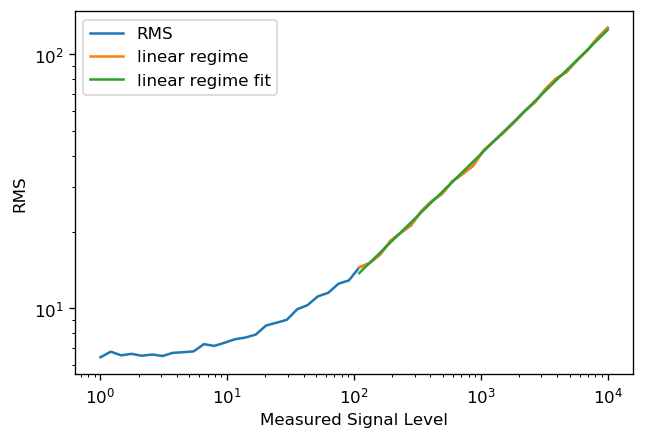

In [59]:
# Question

mask_linear = (measured_signal_levels > 10**2)

fit_linear = np.polyfit(np.log10(measured_signal_levels[mask_linear]),np.log10(noise_levels[mask_linear]),1)
# y  = mx + b
fit_linear_eval = 10**(fit_linear[0]*np.log10(measured_signal_levels[mask_linear]) + fit_linear[1])

print(fit_linear)
plt.loglog(measured_signal_levels,noise_levels, label='RMS')
plt.plot(measured_signal_levels[mask_linear],noise_levels[mask_linear], label='linear regime')
plt.plot(measured_signal_levels[mask_linear],fit_linear_eval,label='linear regime fit')

# Complete
 
plt.ylabel("RMS")
plt.xlabel("Measured Signal Level")

plt.legend()
print(10**0.4772)

What is the behavior you see? What are the two different noise regimes?

Fit a straight line to the "bright" portion of the data (high signal levels) and print the resulting coefficients. Remember that you're looking at a log-log plot, and so you want to fit the logs of the variables. You can add this to the plot in the cell above.

Why does the line have that value of the slope?

**There's a curvy regime and a straight ish regime. I still need to think about the slope**

Now we're going to plot something slightly different. Plot the *variance* this time, and on a linear plot instead of log-log (again vs. measured signal level). Fit a straight line to the data (in linear space) and print the coefficients. Also print the *reciprocal* of the slope.

Where did this slope come from? 

[ 1.59685329 28.2364154 ]
0.6262316076775464


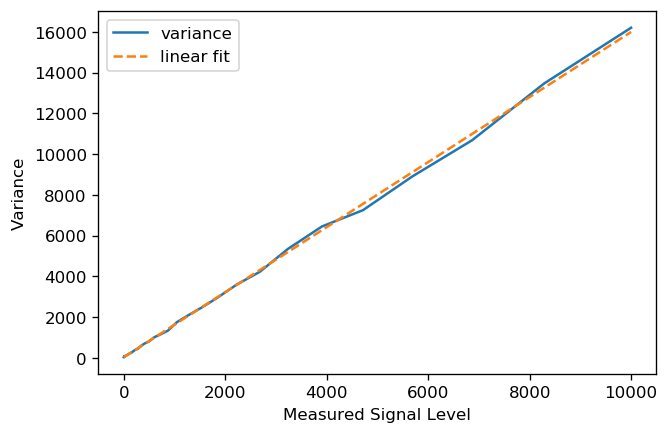

In [60]:
# Question

fit_var = np.polyfit(measured_signal_levels,noise_levels**2,1)
fit_var_eval = np.poly1d(fit_var)

plt.plot(measured_signal_levels,noise_levels**2, label='variance')
plt.plot(measured_signal_levels, fit_var_eval(measured_signal_levels), linestyle='--', label='linear fit')
# Complete    

plt.ylabel("Variance")
plt.xlabel("Measured Signal Level")
plt.legend()

print(fit_var)
print(1/fit_var[0])

The slope here is related to the gain (either proportionally or inversely, depending on how one chooses to define gain). This can be summarized as

$$ \frac{1}{\textrm{gain}} =  \langle \frac{\textrm{Variance}}{\textrm{Mean Signal Level}} \rangle $$

It's a clever and useful trick, or at least it seems like a trick, because the standard deviation plot wasn't affected by the gain at all. Go back and try varying the gain and re-run the plots, and you'll see what does and doesn't change.

**One way to think of it is that the measured signal level is affected linearly by the gain, but the variance is affected by the square of the gain. Dividing these two gives you a linear relation back, but when dividing the square root of the variance, the gain cancels out.**


2) Looking at real bias frames
------

Remember that a bias frame is an image that is exposed for zero seconds; it's just immediately read-out without being exposed to light. You might think that is a pretty boring image, particularly if you're at the telescope and getting ready for a night of observing. But to a camera engineer, bias frames hold lots of information about how the camera is operating.

We're going to look at images from one example LSST sensor; this was taken on a test stand and not the actual camera, so don't take it as representative of real camera performance.

Our first step is, as usual, to look at the image and make sure it seems reasonable.

In [66]:
bias1_file = fits.open("00258334360-S10-det003.fits")
bias1_data = bias1_file[1].data

27605.100463019477


(2048, 576)

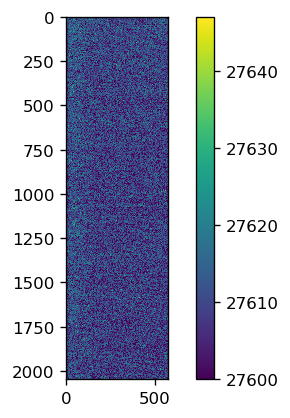

In [82]:
# Question
print(np.mean(bias1_data))
plt.imshow(bias1_data, vmin=27600,cmap='viridis')
plt.colorbar()# complete

bias1_data.shape

Notice that when we plotted `bias1_file[1].data`, the image we get is 2048 by 576 pixels. Because LSST sensors have 16 separate amplifiers, the data from each one of them is put in a different "header data unit" (HDU) in the FITS file. You can get to them by substituting n in `bias1_file[n]`, where n is the amplifier number.

3) Looking for structure
------

The bias looks mostly like Gaussian noise, but if you look carefully some parts of the image look like they have some "structure". 

Let's make a few plots: try plotting the mean of the data *along columns* in one plot, and along *rows* in another.

Start with just a single amplifier, but if you like you can learn more by plotting each amplifier as a different line. Hint: the amplifiers each have different mean levels that you probably want to subtract off.

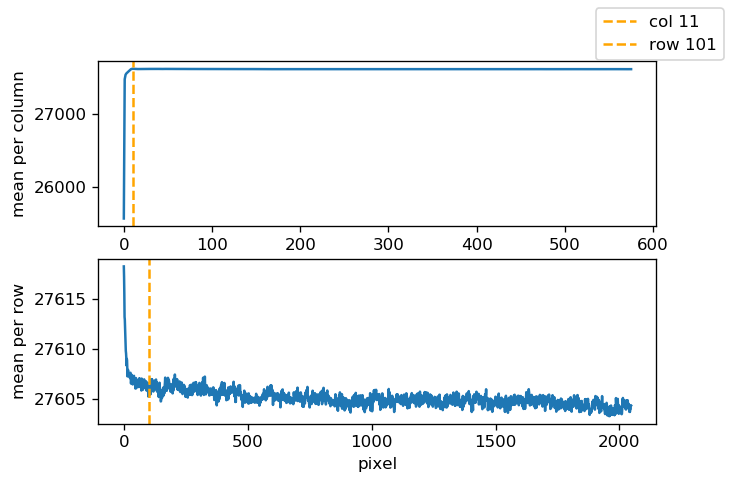

In [101]:
fig,ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(0,576),np.mean(bias1_data,axis=0))
ax[0].set_ylabel('mean per column')
ax[0].axvline(10, color='orange', linestyle='--', label='col 11')
ax[1].plot(np.arange(0,2048),np.mean(bias1_data,axis=1))
ax[1].set_ylabel('mean per row')
ax[1].axvline(100, color='orange', linestyle='--', label='row 101')
ax[1].set_xlabel('pixel')
fig.legend()


These "simple" bias frames turn out to have a lot of structure in them, particularly at the start of columns. This isn't something we can dive much further into, because it's really an electronics problem (that was known about at the time). It's also worth noting that it's fractionally a small effect. We will have to make sure our subsequent analyses are not affected by the issue though.

4) Measuring the noise
------

Bias images usually have some repeatable structure to them, so a useful trick is to use the *difference* of two bias frames taken close in time. Let's measure the standard deviation for the differences between the biases, doing so separately for each amplifier. This isn't the final read noise value yet, because it's still in ADU and not in electrons. We will store the results in a dictionary for later use. 

We load the second image:

In [128]:
bias2_file = fits.open("00258334672-S10-det003.fits")

In [129]:
# Question
measured_stddevs = {}

for hdu in range (1,17): # complete
    hdu_difference = bias1_file[hdu].data - bias2_file[hdu].data # complete
    stddev = np.std(hdu_difference) # complete
    measured_stddevs['amp '+str(hdu)] = stddev # comple
measured_stddevs

{'amp 1': 9.457980927685048,
 'amp 2': 9.469125615340754,
 'amp 3': 9.359179694346206,
 'amp 4': 9.410864043028887,
 'amp 5': 12.24121923224962,
 'amp 6': 9.859962609804752,
 'amp 7': 9.662708085531628,
 'amp 8': 9.84712838890329,
 'amp 9': 11.039278352448566,
 'amp 10': 10.773839466681745,
 'amp 11': 9.711413180620667,
 'amp 12': 10.442833212917893,
 'amp 13': 9.89699060912195,
 'amp 14': 10.9139614470604,
 'amp 15': 10.382393518498514,
 'amp 16': 10.085442944170044}

5) Measuring the gain
---

We have just one more step before we can report the read noise. We need to measure the gains so we can convert the noise in ADU into electrons. To do that, we're going to use the trick we saw at the start of this notebook. We need to add two things though: we want to use pairs of images, to cancel out any fixed spatial patterns, and we need images with significant counts in them so that we're not just measuring read noise. The formula we want to implement is thus:

$$ \frac{1}{\textrm{gain}} =  \langle \frac{(I_1 - I_2)^2}{I_1 + I_2} \rangle $$

where $I_1$ and $I_2$ are the pixel values from each image, and the $\langle$ $\rangle$ brackets denote taking the mean of this ratio over all pixels.

We have some flat field images from those same sensors that we can use:

In [121]:
flat1_file = fits.open("00258342968-S10-det003.fits")
flat2_file = fits.open("00258343136-S10-det003.fits")

Since each amplifier can have a slightly different gain, we want to run this per-HDU and output a table of values. Since we're looping over the HDUs, we can also print the finished read noise values at the same time. Note that those have a factor of $\sqrt{2}$ because we took the difference of two bias frames, so the noise is greater than a single image.

In [127]:
# Question
for hdu in range(1,17):
    flat1_data = flat1_file[hdu].data # complete
    flat2_data = flat2_file[hdu].data # complete
    
    debiased_flat1 = flat1_data - bias1_file[hdu].data # complete
    debiased_flat2 = flat2_data - bias2_file[hdu].data # complete
    
    squared_noise = (debiased_flat1 - debiased_flat2)**2 # complete
    summed_intensity = debiased_flat1 + debiased_flat2 # complete
    
    print(summed_intensity)
    # Some pixels with low counts are likely artifacts and can skew the measurement.
    # It helps to only keep pixels that have significant flux; you can experiment with this cutoff
    ok_values = (summed_intensity > 1000) # complete

    # Remember that as we defined gain above, the formula returns 1/gain.
    reciprocal_gain = np.mean(squared_noise/summed_intensity)# complete 

    print(hdu, reciprocal_gain, 1/reciprocal_gain)

[[ -3 -52  20 ...   2   7  12]
 [  0  22  -5 ... -13  -7 -11]
 [ -3  15  -9 ...  13 -21 -13]
 ...
 [  0  24  -2 ...  33  -7   1]
 [  3 -16   5 ... -14 -10 -13]
 [ -2   3   2 ...   1  15  -6]]
1 nan nan
[[ -9 -19  50 ...   4  15  18]
 [ -9  25  -2 ...  -5  15  10]
 [ -1 -28  -7 ...   3 -27 -15]
 ...
 [ -9  26   8 ...  23   8   5]
 [ -2  -3  14 ... -12   0   1]
 [ -7  17   1 ...  17  -2  33]]
2 nan nan
[[  7 -27  24 ...   3   4  11]
 [ -4   8   4 ...  15  -9  -6]
 [  1  23   6 ...  22  -3 -18]
 ...
 [ -2   8  10 ...  15   4 -12]
 [ -3  -4  -5 ...  19  14 -17]
 [  3  20   4 ...  -8  -5  16]]
3 nan nan
[[  1 -26  26 ...   4  17 -10]
 [  2  18  13 ...  32 -19  27]
 [ 10  14  -6 ...   2  -2 -12]
 ...
 [ -2   6  -6 ...  13  15  -2]
 [  0  -6   8 ...  -6 -14  -3]
 [  3 -10  16 ...  -6  -7  22]]
4 nan nan
[[  0  -3  38 ...  -2   9  17]
 [  7  13 -22 ...   6  -5  13]
 [  3  16  14 ...  35   3 -16]
 ...
 [ -4  -1   1 ...   5 -10  -1]
 [ -3   7 -17 ...  11  -5  -3]
 [  2   2  13 ...   6  -6   7]]


/Users/andreia_carrillo/anaconda3/envs/pymc3_dsfp/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/andreia_carrillo/anaconda3/envs/pymc3_dsfp/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


[[ -4  -8  23 ...  30  18  12]
 [ -5  15   3 ...  28   2  28]
 [ -8 -13  10 ...  -2 -11  -5]
 ...
 [ -4   3  -3 ...  35 -10   9]
 [-11  16   3 ... -11 -23 -10]
 [ -5   0   5 ... -11   1  -8]]
10 nan nan
[[ -6 -40  11 ...  -6   1  10]
 [ -9   2 -12 ... -14  -8  25]
 [  2 -19 -32 ...   1 -13 -32]
 ...
 [  4  -1  -2 ...   8 -10   1]
 [ -3 -28 -17 ... -11 -22 -11]
 [ -6 -13 -11 ...   8  -1  11]]
11 nan nan
[[  1 -17  42 ...  25  25  14]
 [ -3  22  31 ...  20   8   4]
 [  1   5  24 ...  11   3  36]
 ...
 [  3   8 -14 ...  15   0  17]
 [ -8   8   0 ... -11  -3  -1]
 [  7  21  -6 ... -20  15  11]]
12 nan nan
[[-13 -49  53 ...  29  -1  26]
 [ -5   6  16 ...   6  -2  32]
 [ -5  -3   3 ...  12 -17   1]
 ...
 [ -2  25  -9 ...  -1   7   5]
 [  2  -4   3 ...  -6  -2 -17]
 [  0   1   1 ...   3 -23  30]]
13 nan nan
[[ -1 -11  41 ...  34  31  33]
 [ -6   8  23 ...   7   5  41]
 [  2  -2  35 ...  46  16  26]
 ...
 [ -4   4  -2 ...  12  28   2]
 [ -1  -8  13 ...  11  -9 -23]
 [ -4   3   7 ...   4  -8  2

I got values of about 0.7 for the gain, and read noise values around 5 e-. Did those work out for you? 